<h1>Process Data</h1>
<h4>Haley Johnson</h4>

<p>Notebook to extract, combine and transform data</p>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os 

<h2>Manipulate Happiness Data</h2>

In [2]:
html = pd.read_html("happiest_cities.html")

In [3]:
happiness_df = html[0]

In [4]:
happiness_df = happiness_df.rename(columns = {'City': 'Location'})

happiness_df['state'] = happiness_df['Location'].apply(lambda s: s.split(",")[-1])
happiness_df['city'] = happiness_df['Location'].apply(lambda s: s.split(",")[0])

happiness_df = happiness_df.drop(columns = ['Location'])

In [5]:
happiness_df['state'] = happiness_df['state'].str.strip().str.upper()
happiness_df['city'] = happiness_df['city'].str.strip().str.upper()

<h2>Manipulate Transportation Data</h2>

In [6]:
locations_df = pd.read_csv("EPA_SmartLocationDatabase_V3_Jan_2021_Final.csv")

<h4>Remove Rows Where Location Is Missing</h4>

In [7]:
locations_df[pd.isnull(locations_df['CBSA_Name'])].shape

(17095, 117)

In [8]:
locations_df = locations_df[pd.isnull(locations_df['CBSA_Name']) == False]

<h4>Adding Percent Columns</h4>

In [9]:
def calc_pct_protect(s):
    '''
    Takes in a row of a dataframe
    Returns the percentage of land
    that is protected'''
    
    total_area = s['Ac_Total']
    unprotected_area = s['Ac_Unpr']
    protected_area = total_area - unprotected_area
    try:
        div = (protected_area / total_area)
    except:
        div = 0
    return div
    

In [10]:
locations_df['PCT_protected'] = locations_df.apply(calc_pct_protect, axis = 1)

locations_df['PCT_water'] = locations_df['Ac_Water'] / locations_df['Ac_Total']
locations_df['pct_D5AR'] = locations_df['D5AR'] / locations_df['CBSA_POP']

In [11]:
locations_df.shape

(203645, 120)

<h4>Setting Ranking Columns as Category</h4>

In [12]:
rankings = ['D2A_Ranked', 'D2B_Ranked', 'D3B_Ranked', 'D4A_Ranked']

for rank in rankings:
    locations_df[rank] = locations_df[rank].astype('category')

<h4>Get City and State Names</h4>

In [13]:
locations_df['CBSA_Name'] = locations_df['CBSA_Name'].astype(str)

In [14]:
locations_df['metro_area_cities'] = locations_df['CBSA_Name'].apply(lambda s: str(s).split(",")[0])
locations_df['metro_area_states'] = locations_df['CBSA_Name'].apply(lambda s: str(s).split(",")[-1])

locations_df['city'] = locations_df['metro_area_cities'].apply(lambda s: s.split("-"))
locations_df['state'] = locations_df['metro_area_states'].apply(lambda s: s.split("-"))

In [15]:
locations_df = locations_df.drop(columns = ['metro_area_cities', 'metro_area_states'])

<h3>Explode</h3>

In [16]:
exploded = locations_df.explode('city')
exploded = exploded.explode('state')
exploded = exploded.drop_duplicates()

In [17]:
exploded['city'] = exploded['city'].str.strip().str.upper()
exploded['state'] = exploded['state'].str.strip().str.upper()

<h2>Joining Happiness and Transportation Dataframes</h2>

<h4>Check that columns match</h4>

<p><b>St. Paul Minnestoa</b></p>

In [21]:
happiness_df[happiness_df['state'] == 'MN'][['city', 'state']]

,city,state
11,MINNEAPOLIS,MN
45,ST. PAUL,MN


In [22]:
exploded[exploded['state'] == 'MN'][['city', 'state']]

,city,state
125050,MINNEAPOLIS,MN
125050,ST. PAUL,MN
125050,BLOOMINGTON,MN
125051,MINNEAPOLIS,MN
125051,ST. PAUL,MN
...,...,...
217181,ST. PAUL,MN
217181,BLOOMINGTON,MN
217184,MINNEAPOLIS,MN
217184,ST. PAUL,MN


<p><b>New York City, NY</b></p>

In [23]:
happiness_df[happiness_df['state'] == 'NY'][['city', 'state']]

,city,state
43,YONKERS,NY
57,NEW YORK,NY
130,ROCHESTER,NY
135,BUFFALO,NY


In [24]:
exploded[exploded['state'] == 'NY'][['city', 'state']]

,city,state
141064,NEW YORK,NY
141064,NEWARK,NY
141064,JERSEY CITY,NY
141065,NEW YORK,NY
141065,NEWARK,NY
...,...,...
191967,NEWARK,NY
191967,JERSEY CITY,NY
191968,NEW YORK,NY
191968,NEWARK,NY


<p><b>Washington, D.C.</b></p>

In [25]:
happiness_df[happiness_df['state'] == 'DC'][['city', 'state']]

,city,state
84,WASHINGTON,DC


In [26]:
happiness_df[happiness_df['city'] == 'Arlington'][['city', 'state']]

,city,state


In [27]:
happiness_df[happiness_df['city'] == 'Alexandria'][['city', 'state']]

,city,state


In [28]:
exploded[exploded['state'] == 'DC'][['city', 'state']]

,city,state
15824,WASHINGTON,DC
15824,ARLINGTON,DC
15824,ALEXANDRIA,DC
15825,WASHINGTON,DC
15825,ARLINGTON,DC
...,...,...
212686,ARLINGTON,DC
212686,ALEXANDRIA,DC
212694,WASHINGTON,DC
212694,ARLINGTON,DC


<h4>Joining</h4>

In [29]:
matches = exploded.merge(happiness_df, on = ['state', 'city'])

In [63]:
# NOTE TO SELF: When you add new columns up above, you need to adjust these 
vals = list(matches.columns)[11:-8] + list(happiness_df.columns)[:-2]
vals.append('region')
df = pd.pivot_table(matches, index = ['city', "state"], values = vals, aggfunc = 'mean')

In [64]:
df = df.reset_index()

<h4>Add in Regions</h4>

<p>Based on <a href="https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf">census designations</a></p>

In [66]:
regions = {}

regions['pacific'] = ['CA', 'OR', 'WA', 'HI', 'AK']

regions['mountain west'] = ['ID', 'NV', 'MT','WY', 'UT', 'CO', 'AZ', 'NM']

regions['west north central'] = ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO']

regions['west south central'] = ['TX', 'OK', 'AR', 'LA']

regions['east north central'] = ['WI', 'IL', 'MI', 'IN', 'OH']

regions['east south central'] = ['KY', 'TN', 'MS', 'AL']

regions['south atlantiic'] = ['FL', 'GA', 'SC', 'NC', 'VA', 'WV', 'DC', 'MD', 'DE']

regions['middle atlantic'] = ['PA', 'NY', 'NJ']

regions['new england'] = ['ME', 'VT', 'NH', 'MA', 'CT', 'RI']

regions['us territories'] = ['PR']

In [67]:
def get_region(s):
    keys = list(regions.keys())
    for key in keys:
        if s in regions[key]:
            return key
    return None

In [69]:
df['region'] = df['state'].apply(get_region)

<h2>Data Visualization</h2>

<h3>Example of Why Aggregation Is Helpful</h3>

Text(0.5, 0.98, 'Effect of Aggregating by City on Analysis')

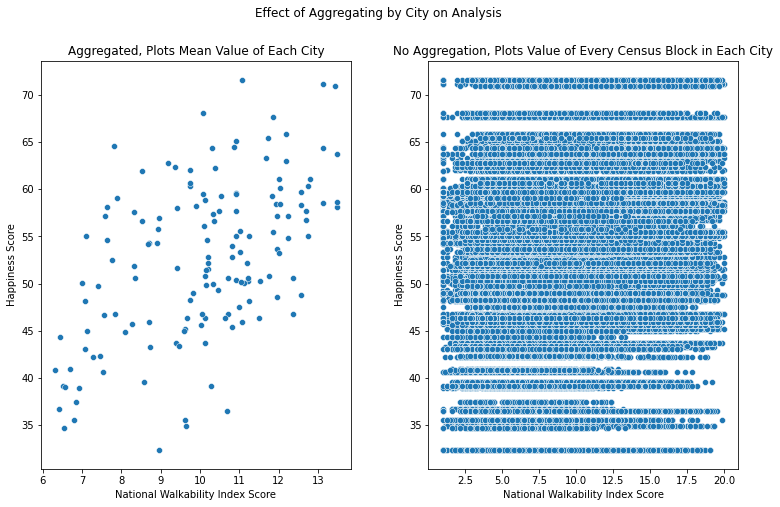

In [53]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(12.5, 7.5)
fig.subplots_adjust(hspace=0.5, wspace = 0.25)

sns.scatterplot(x = 'NatWalkInd', y = 'Total Score', data = df, ax = axes[0])
sns.scatterplot(x = 'NatWalkInd', y = 'Total Score', data = matches, ax = axes[1])

# labels
axes[0].set_title('Aggregated, Plots Mean Value of Each City')
axes[0].set(ylabel = 'Happiness Score', xlabel = 'National Walkability Index Score')
axes[1].set_title('No Aggregation, Plots Value of Every Census Block in Each City')
axes[1].set(ylabel = 'Happiness Score', xlabel = 'National Walkability Index Score')

# annotations
# axes[0].annotate('figure pixels', xy=(160, 55), xycoords='figure pixels')

fig.suptitle("Effect of Aggregating by City on Analysis")

<h3>Actual Visualization</h3>

<AxesSubplot:xlabel='Community & Environment', ylabel='pct_D5AR'>

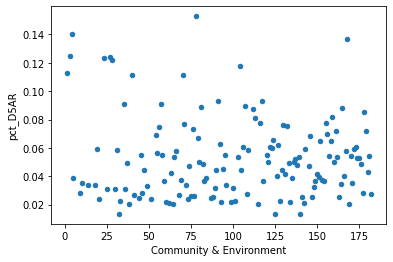

In [54]:
sns.scatterplot(y = 'pct_D5AR', x = 'Community & Environment', data = df)

<AxesSubplot:xlabel='Total Score', ylabel='Pct_AO0'>

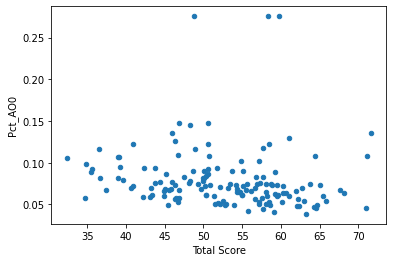

In [55]:
sns.scatterplot(y = 'Pct_AO0', x = 'Total Score', data = df)

Text(0.5, 1.0, 'Scatterplot of Walkability vs Happiness Scores')

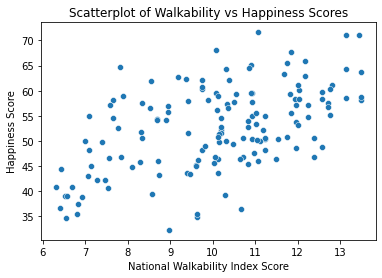

In [81]:
g = sns.scatterplot(x = 'NatWalkInd', y = 'Total Score', data = df)
g.set(xlabel = 'National Walkability Index Score', ylabel = 'Happiness Score')
g.set_title("Scatterplot of Walkability vs Happiness Scores")

Text(0.5, 1.0, 'Scatterplot of Walkability vs Happiness Scores')

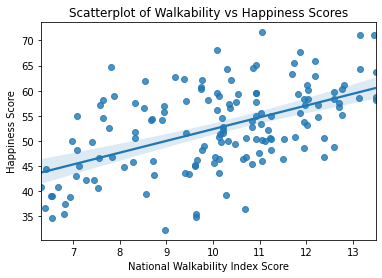

In [82]:
g = sns.regplot(x = 'NatWalkInd', y = 'Total Score', data = df)
g.set(xlabel = 'National Walkability Index Score', ylabel = 'Happiness Score')
g.set_title("Scatterplot of Walkability vs Happiness Scores")

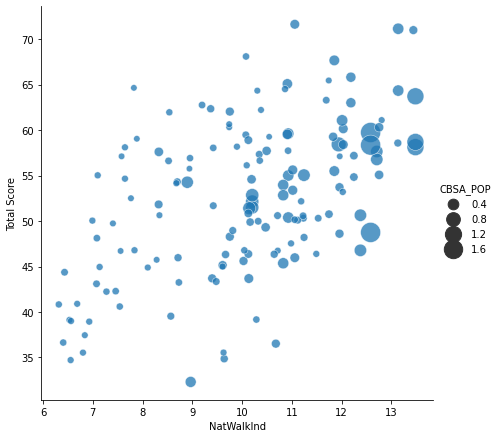

In [75]:
g = sns.relplot(x = "NatWalkInd", y = "Total Score", size = "CBSA_POP",
            sizes = (40, 400), alpha = 0.75, palette = "muted",
            height = 6, data = df)

# g.set(xlabel = 'National Walkability Index Score', ylabel = 'Happiness Score')
# g.set_title("Scatterplot of Walkability vs Happiness Scores")

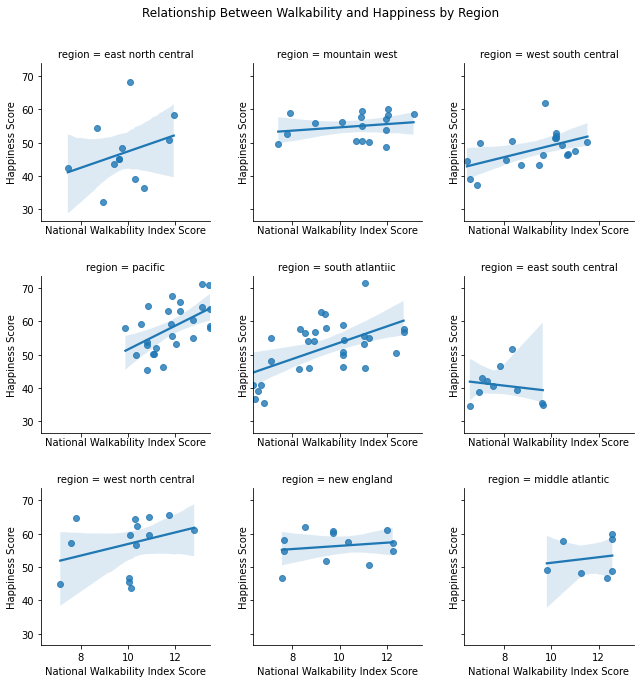

In [95]:
g = sns.FacetGrid(df, col="region", col_wrap = 3)
g.map(sns.regplot, "NatWalkInd", "Total Score")
g.set(xlabel = 'National Walkability Index Score', ylabel = 'Happiness Score')

g.fig.suptitle("Relationship Between Walkability and Happiness by Region", y = 1.05)
g.fig.subplots_adjust(wspace = 0.25, hspace = 0.35)

Text(0.5, 0.98, 'Walkability Index vs Happiness Score Components')

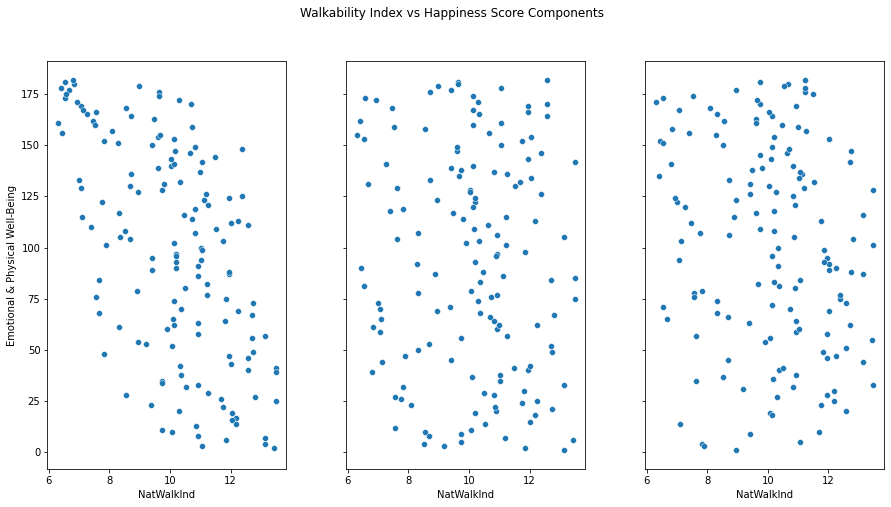

In [76]:
fig, axes = plt.subplots(1, 3, sharey= True)
fig.set_size_inches(15, 7.5)
fig.subplots_adjust(hspace=0.5, wspace = 0.25)

axes[0] = sns.scatterplot(x = 'NatWalkInd', y = 'Emotional & Physical Well-Being', data = df, ax = axes[0])
axes[1] = sns.scatterplot(x = 'NatWalkInd', y = 'Income & Employment', data = df, ax = axes[1])
axes[2] = sns.scatterplot(x = 'NatWalkInd', y = 'Community & Environment', data = df, ax = axes[2])

fig.suptitle("Walkability Index vs Happiness Score Components")

<p>People Enjoy Living in Walkable Community, but not when it comes with the trade off of not owning a vehicle</p>
<p>Owning a car isn't a simple choice of walkability vs not, household wealth is a big confounding variable here</p>

<h3>Average Happiness Score by Walkability Score Level</h3>

Text(0.5, 0.98, 'Happiness Scores vs Walkability Index Ranking')

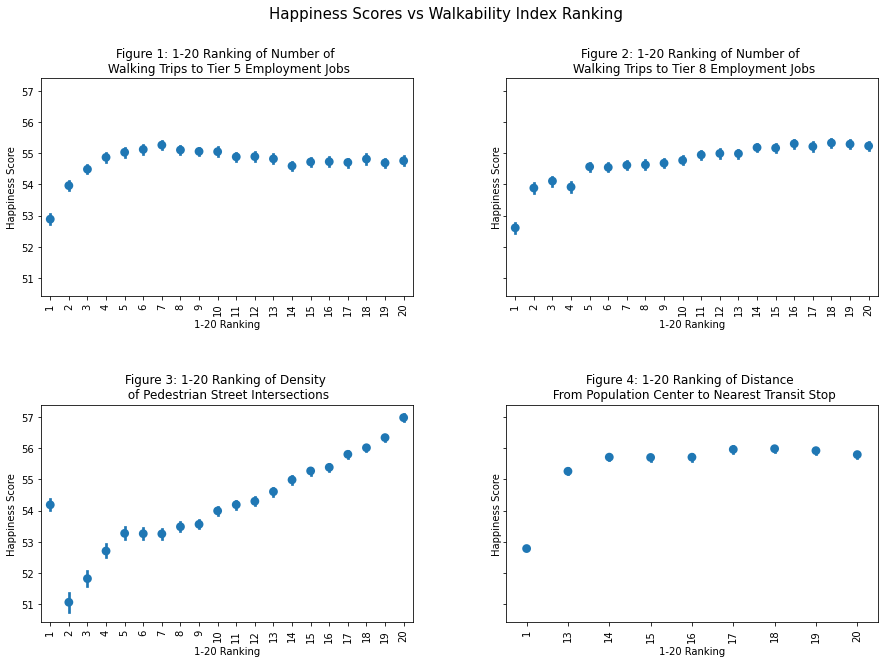

In [101]:
fig, axes = plt.subplots(2, 2, sharey= True)
fig.set_size_inches(15, 10)
fig.subplots_adjust(hspace=0.5, wspace = 0.25)

targets = ['D2A_Ranked', 'D2B_Ranked', 'D3B_Ranked', 'D4A_Ranked']

for i, ax in enumerate(axes.flatten()):
    g = sns.pointplot(x = targets[i], y = 'Total Score', data = matches, join = False, ax = ax)
    g.set_xticklabels(g.get_xticklabels(), rotation = 90)
    g.set_xlabel(xlabel = '1-20 Ranking')
    g.set_ylabel('Happiness Score')
    
# set titles
axes[0][0].set_title('Figure 1: 1-20 Ranking of Number of \n Walking Trips to Tier 5 Employment Jobs')
axes[0][1].set_title('Figure 2: 1-20 Ranking of Number of \n Walking Trips to Tier 8 Employment Jobs')
axes[1][0].set_title('Figure 3: 1-20 Ranking of Density \n of Pedestrian Street Intersections')
axes[1][1].set_title('Figure 4: 1-20 Ranking of Distance \n From Population Center to Nearest Transit Stop')

fig.suptitle("Happiness Scores vs Walkability Index Ranking", fontsize = 15)

<h3>Walkability Scores for Happiest Cities</h3>

In [ ]:
# weak inverse relatioship between not owning a car and happiness
# wealth as a confounding variable?
sns.scatterplot(x = 'Pct_AO0', y = 'Total Score', data = df )

In [ ]:
sns.scatterplot(x = 'PCT_protected', y = 'Total Score', data = df)

In [ ]:
sns.scatterplot(x = 'PCT_protected', y = 'Community & Environment', data = df)

<h4>Association Between Density and Housing</h4>

In [ ]:
# generally positive
# D1A = Residential density
sns.scatterplot(x = 'D1A', y = 'Total Score', data = df)

In [ ]:
sns.barplot(x = df['D1A'], y = df.index, data = df)